# 02. PyTorch Workflow Fundamentals

## What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

For now, we'll use this workflow to predict a simple straight line but the workflow steps can be repeated and changed depending on the problem you're working on.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Check PyTorch version
torch.__version__

'2.6.0+cu126'

## 1. Data (preparing and loading)

![machine learning is a game of two parts: 1. turn your data into a representative set of numbers and 2. build or pick a model to learn the representation as best as possible](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png)

Let's create our data as a straight line.

We'll use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to create the data with known **parameters** (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent).

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

### Split data into training and test sets 

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |


In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [5]:
# Create train/valid split
val_split = int(0.2 * len(X_train)) # 80% of train data used for training set, 20% for validating
idx = list(range(len(X_train)))
train_idx, val_idx = torch.utils.data.random_split(idx, [train_split - val_split, val_split])
X_val = X_train[val_idx].clone()
y_val = y_train[val_idx].clone()
X_train = X_train[train_idx].clone()
y_train = y_train[train_idx].clone()

len(X_train), len(y_train), len(X_val), len(y_val)

(64, 64, 16, 16)

We've got 64 samples for training (`X_train` & `y_train`), 16 samples for validating (`X_train` & `y_train`) and 20 samples for testing (`X_test` & `y_test`).

In [8]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     val_data=X_val, 
                     val_labels=y_val, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data.cpu(), train_labels.cpu(), c="b", s=4, label="Training data")

    # Plot validating data in blue
    plt.scatter(val_data.cpu(), val_labels.cpu(), c="m", s=4, label="Validating data")

    # Plot test data in green
    plt.scatter(test_data.cpu(), test_labels.cpu(), c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data.cpu(), predictions.cpu(), c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

    plt.show()


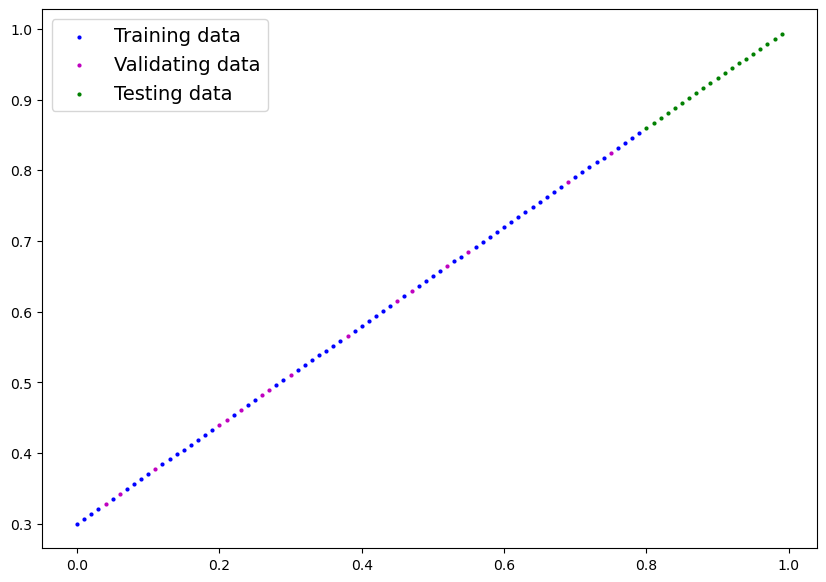

In [9]:
plot_predictions(X_train, y_train, X_val, y_val, X_test, y_test)

## 2. Build model

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [torch.nn](https://pytorch.org/docs/stable/nn.html), [torch.optim](https://pytorch.org/docs/stable/optim.html), [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their uses cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 


In [10]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear()
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        x = self.linear_layer(x)
        return x


### Checking the contents of a PyTorch model
Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using [`.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters). 

In [11]:
# Set manual seed since nn.Parameter are randomly initialzied
# Function for setting the seed
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = LinearRegressionModel()
model

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [12]:
# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [13]:
# List named parameters 
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

Notice the outputs of `model.state_dict()`, the `nn.Linear()` layer created a random `weight` and `bias` parameter for us.

Now let's put our model on the GPU (if it's available).

We can change the device our PyTorch objects are on using `.to(device)`.

First let's check the model's current device.

In [14]:
# Check model device
next(model.parameters()).device

device(type='cpu')

Let's change it to be on the GPU (if it's available).

In [15]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model.parameters()).device

device(type='cuda', index=0)

If you do have access to a CUDA-enabled GPU, you should see an output of something like:
```
device(type='cuda', index=0)
```

### Making predictions using `torch.inference_mode()` 
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's make some predictions. 

In [16]:
# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Make predictions with model
with torch.inference_mode(): 
    y_preds = model(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model(X_test)

We used [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) as a [context manager](https://realpython.com/python-with-statement/) (that's what the `with torch.inference_mode():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

> **Note:** In older PyTorch code, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things,
`torch.inference_mode()` is newer, potentially faster and preferred. See this [Tweet from PyTorch](https://twitter.com/PyTorch/status/1437838231505096708?s=20) for more.

We've made some predictions, let's see what they look like. 

In [17]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds[:5]}")

Number of testing samples: 20
Number of predictions made: 20
Predicted values:
tensor([[1.4416],
        [1.4493],
        [1.4569],
        [1.4646],
        [1.4722]], device='cuda:0')


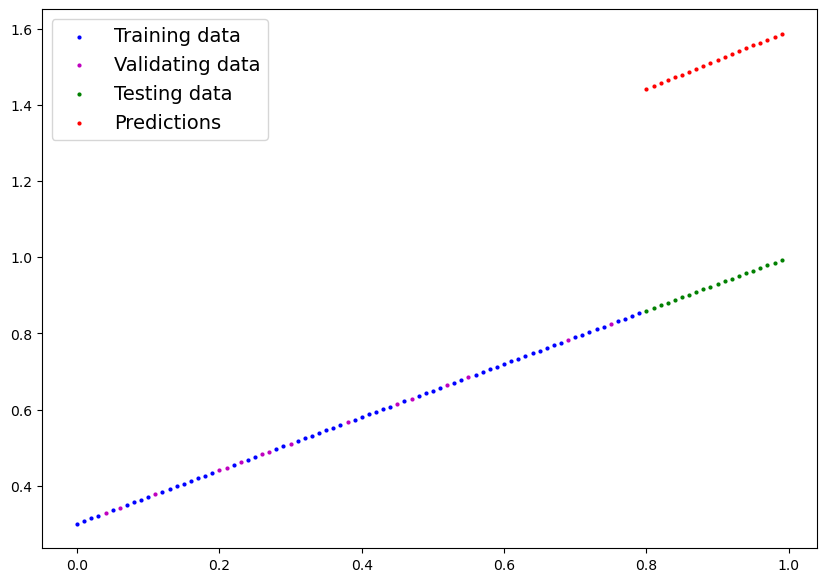

In [18]:
plot_predictions(X_train, y_train, X_val, y_val, X_test, y_test, predictions=y_preds)

In [19]:
errors = y_test - y_preds
errors[:5]

tensor([[-0.5816],
        [-0.5823],
        [-0.5829],
        [-0.5836],
        [-0.5842]], device='cuda:0')

Those predictions look pretty bad...

## 3. Train model

### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are: 

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | 

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function. 

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). 

In [20]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **validating loop**).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The validating loop involves going through the validating data and evaluating how good the patterns are that the model learned on the training data (the model never see's the validating data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb: 
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* stepping them (`optimizer.step()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`)



### PyTorch validating (testing) loop

As for the validating loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the validating loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during validating (testing), they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


In [21]:
set_seed(42)

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_val = X_val.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
val_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Validating

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
        # 1. Forward pass on validating data
        val_pred = model(X_val)

        # 2. Caculate loss on validating data
        val_loss = loss_fn(val_pred, y_val.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        epoch_count.append(epoch)
        train_loss_values.append(loss.cpu().detach().numpy())
        val_loss_values.append(val_loss.cpu().detach().numpy())
        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Val Loss: {val_loss} ")

Epoch: 0 | MAE Train Loss: 0.5563375949859619 | MAE Val Loss: 0.5407528877258301 
Epoch: 10 | MAE Train Loss: 0.439693808555603 | MAE Val Loss: 0.4267544746398926 
Epoch: 20 | MAE Train Loss: 0.32304999232292175 | MAE Val Loss: 0.31275609135627747 
Epoch: 30 | MAE Train Loss: 0.20640619099140167 | MAE Val Loss: 0.19875772297382355 
Epoch: 40 | MAE Train Loss: 0.08976239711046219 | MAE Val Loss: 0.08475935459136963 
Epoch: 50 | MAE Train Loss: 0.025294067338109016 | MAE Val Loss: 0.02528310753405094 
Epoch: 60 | MAE Train Loss: 0.021432846784591675 | MAE Val Loss: 0.02036473900079727 
Epoch: 70 | MAE Train Loss: 0.017917536199092865 | MAE Val Loss: 0.016821185126900673 
Epoch: 80 | MAE Train Loss: 0.01442304439842701 | MAE Val Loss: 0.013480119407176971 
Epoch: 90 | MAE Train Loss: 0.010928546078503132 | MAE Val Loss: 0.010139057412743568 


Looks like our loss is going down with every epoch, let's plot it to find out.

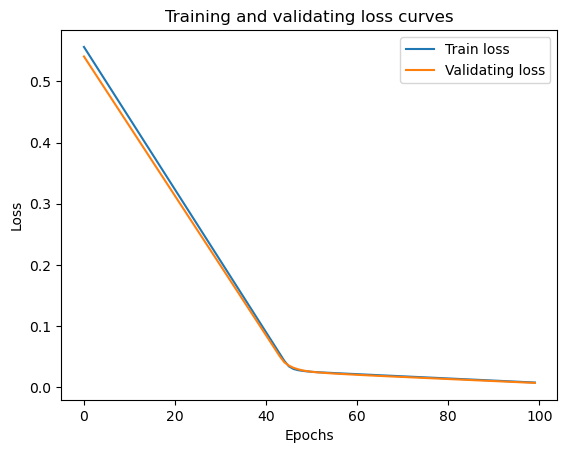

In [22]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, val_loss_values, label="Validating loss")
plt.title("Training and validating loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Nice! The **loss curves** show the loss going down over time. Remember, loss is the measure of how *wrong* your model is, so the lower the better.

But why did the loss go down?

Well, thanks to our loss function and optimizer, the model's internal parameters (`weights` and `bias`) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's [`.state_dict()`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) to see see how close our model gets to the original values we set for weights and bias.



In [23]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'linear_layer.weight': tensor([[0.6636]], device='cuda:0'), 'linear_layer.bias': tensor([0.3159], device='cuda:0')})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Wow! How cool is that?

Our model got very close to calculate the exact original values for `weight` and `bias` (and it would probably get even closer if we trained it for longer).

> **Exercise:** Try changing the `epochs` value above to 200, what happens to the loss curves and the weights and bias parameter values of the model?

It'd likely never guess them *perfectly* (especially when using more complicated datasets) but that's okay, often you can do very cool things with a close approximation.

This is the whole idea of machine learning and deep learning, **there are some ideal values that describe our data** and rather than figuring them out by hand, **we can train a model to figure them out programmatically**.

## 4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/validating loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [24]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    # 3. Make sure the calculations are done with the model and data on the same device
    # in our case, we haven't setup device-agnostic code yet so our data and model are
    # on the CPU by default.
    model.to(device)
    X_test = X_test.to(device)
    y_preds = model(X_test)
y_preds[:5]

tensor([[0.8468],
        [0.8534],
        [0.8601],
        [0.8667],
        [0.8733]], device='cuda:0')

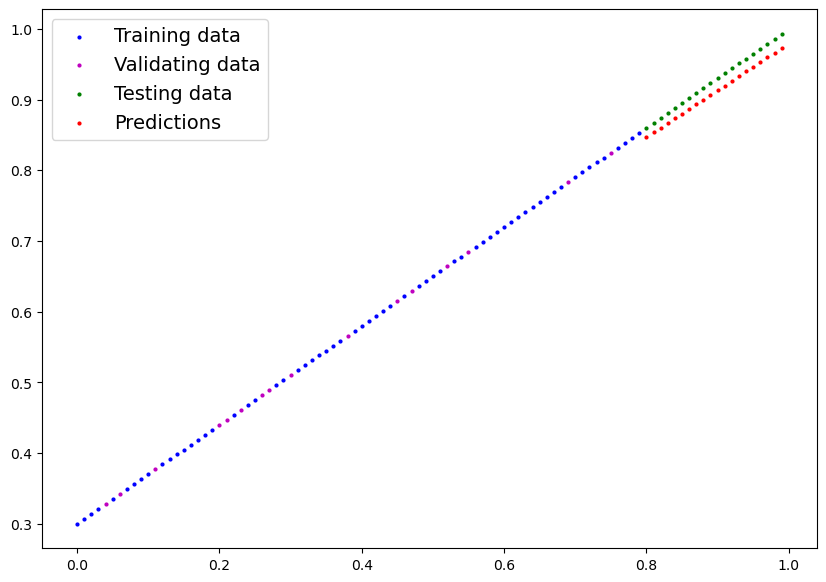

In [25]:
plot_predictions(X_train, y_train, X_val, y_val, X_test, y_test, predictions=y_preds)

## 5. Saving and loading a PyTorch model

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialzed object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


### Saving a PyTorch model's `state_dict()`

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model1.pth`.


In [26]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "02_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\02_pytorch_workflow_model.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/02_pytorch_workflow_model.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`? 

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by created another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dit()`.

In [27]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the model on the available device
loaded_model = loaded_model.to(device)

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol> 
</details>



In [28]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [29]:
# Compare previous model predictions with loaded model predictions (these should be the same)
len(y_preds), sum(y_preds == loaded_model_preds)

(20, tensor([20], device='cuda:0'))

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.

> **Note:** There are more methods to save and load PyTorch models but I'll leave these for extra-curriculum and further reading. See the [PyTorch guide for saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models) for more. 

## Extra-curriculum
* Spend 10-minutes scrolling through and checking out the [PyTorch documentation cheatsheet](https://pytorch.org/tutorials/beginner/ptcheat.html) for all of the different PyTorch modules you might come across.
* Spend 10-minutes reading the [loading and saving documentation on the PyTorch website](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to become more familiar with the different saving and loading options in PyTorch.
* Read [What is `torch.nn`, really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard for a deeper understanding of how one of the most important modules in PyTorch works.